In [1]:
import os
import numpy as np
import pandas as pd
import gdown
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
# pip install torchsummary

In [2]:
images = []
lesions = []
import os
if not os.path.exists('./LIDC_crops'):
    url = 'https://drive.google.com/uc?id=1z86AnODkJJa8v2RkAM6LADkw07Tf7TUH'
    gdown.download(url, './LIDC_DLCV_version.zip', quiet=False)
    !unzip ./LIDC_DLCV_version.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1z86AnODkJJa8v2RkAM6LADkw07Tf7TUH
To: /content/LIDC_DLCV_version.zip
112MB [00:00, 120MB/s]  


In [3]:
!cd LIDC_crops/LIDC_DLCV_version/test/images && ls | head

LIDC-IDRI-0007_z-102.0_c0.png
LIDC-IDRI-0007_z-104.5_c0.png
LIDC-IDRI-0007_z-107.0_c0.png
LIDC-IDRI-0007_z-37.0_c0.png
LIDC-IDRI-0007_z-39.5_c0.png
LIDC-IDRI-0007_z-42.0_c0.png
LIDC-IDRI-0007_z-44.5_c0.png
LIDC-IDRI-0007_z-47.0_c0.png
LIDC-IDRI-0007_z-49.5_c0.png
LIDC-IDRI-0007_z-52.0_c0.png


In [4]:
!cd LIDC_crops/LIDC_DLCV_version/test/lesions && ls | head

LIDC-IDRI-0007_z-102.0_c0_l0.png
LIDC-IDRI-0007_z-102.0_c0_l1.png
LIDC-IDRI-0007_z-102.0_c0_l2.png
LIDC-IDRI-0007_z-102.0_c0_l3.png
LIDC-IDRI-0007_z-104.5_c0_l0.png
LIDC-IDRI-0007_z-104.5_c0_l1.png
LIDC-IDRI-0007_z-104.5_c0_l2.png
LIDC-IDRI-0007_z-104.5_c0_l3.png
LIDC-IDRI-0007_z-107.0_c0_l0.png
LIDC-IDRI-0007_z-107.0_c0_l1.png


In [5]:
sorted(glob.glob(os.path.join("LIDC_crops/LIDC_DLCV_version", "train", "images", "*.png")))[:10]

['LIDC_crops/LIDC_DLCV_version/train/images/LIDC-IDRI-0001_z-105.0_c0.png',
 'LIDC_crops/LIDC_DLCV_version/train/images/LIDC-IDRI-0001_z-107.5_c0.png',
 'LIDC_crops/LIDC_DLCV_version/train/images/LIDC-IDRI-0001_z-110.0_c0.png',
 'LIDC_crops/LIDC_DLCV_version/train/images/LIDC-IDRI-0001_z-112.5_c0.png',
 'LIDC_crops/LIDC_DLCV_version/train/images/LIDC-IDRI-0001_z-115.0_c0.png',
 'LIDC_crops/LIDC_DLCV_version/train/images/LIDC-IDRI-0001_z-117.5_c0.png',
 'LIDC_crops/LIDC_DLCV_version/train/images/LIDC-IDRI-0001_z-120.0_c0.png',
 'LIDC_crops/LIDC_DLCV_version/train/images/LIDC-IDRI-0001_z-122.5_c0.png',
 'LIDC_crops/LIDC_DLCV_version/train/images/LIDC-IDRI-0001_z-125.0_c0.png',
 'LIDC_crops/LIDC_DLCV_version/train/images/LIDC-IDRI-0002_z-100.75_c0.png']

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# image extract

In [7]:
 import torchvision.transforms.functional as TF

class LIDC_DLCV(torch.utils.data.Dataset):

    def __init__(self, state, mask_idx, path="LIDC_crops/LIDC_DLCV_version", output_size=128):
        assert state in ["test", "val", "train"]
        
        self.path = path
        self.state = state
        self.images = sorted(glob.glob(os.path.join(path, state, "images", "*.png")))  # os.path.join: 路径拼接。 glob.glob: 遍历所有文件
        self.mask_convert = {0: "_l0", 1: "_l1", 2: "_l2", 3: "_l3"}                   # get the annotation given by different experts 
        self.mask_idx = mask_idx
        self._output_size = output_size                                                # resize dimension
        
    def __len__(self):
        return len(self.images)

    def _transform(self, image, mask):
        "Do transformation and return"

        # Resize
        resize = transforms.Resize(size=(self._output_size, self._output_size))
        image = resize(image)
        mask = resize(mask)

        # Augmentation
        #aug_rotate = transforms.RandomRotation(degrees=(0, 90))                 
        aug_flip = transforms.RandomHorizontalFlip()
        #image = aug_rotate(image)
        image = aug_flip(image)
        #mask = aug_rotate(mask)
        mask = aug_flip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask[mask > 0] = 1.0
        return image, mask

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        mask_path = os.path.basename(self.images[idx])[:-4] + self.mask_convert[self.mask_idx] + ".png"     # 取到倒数第四项再加上convert的l0 就是leision的图片路径
        mask = Image.open(os.path.join(self.path, self.state, "lesions", mask_path))
        img, mask = self._transform(img, mask)
        return img, mask

In [8]:
batch_size = 64
# Train and test data
trainset = LIDC_DLCV(state="train", mask_idx=0)
print("Number of training samples are", len(trainset))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = LIDC_DLCV(state="test", mask_idx=0)
print("Number of test samples are", len(trainset))
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
valset = LIDC_DLCV(state="val", mask_idx=0)
print("Number of validation samples are", len(valset))
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=3)

Number of training samples are 8843
Number of test samples are 8843
Number of validation samples are 1993


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
for X_batch, Y_batch in train_loader:
  X_batch = X_batch.to(device)
  Y_batch = Y_batch.to(device)
print(X_batch.size(),Y_batch.size())
##why N = 11?

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([11, 1, 128, 128]) torch.Size([11, 1, 128, 128])


In [10]:
# reduce the situation of class imbalance as the input of pos_weight in loss function
black = 0
total_pix = 0
for X_val, Y_val in train_loader:
    total_pix += 128*128*Y_val.size()[0]                     # all the pixels in total. an image has 128 * 128 pixels while if there are Y_val.size[0] images, calculate the pixels in total
    black += 128*128*Y_val.size()[0] - torch.sum(Y_val)      # if we assume there is a grey image which only contains 0 and 1, so torch.sum(Y_cal) is the sum of all the element and it can shows the number of "1"
print(black/total_pix)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(0.9941)


# train model

In [11]:
def train(model, opt, epochs, data_tr, data_val, loss_fn=None):
    X_val, Y_val = next(iter(data_val))
    loss_train = []
    loss_val = []

    for epoch in tqdm(range(epochs), unit='epoch'):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss_tr = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            if loss_fn == None:
                weights = torch.tensor([0.9941]).to(device)
                loss_fun = torch.nn.BCEWithLogitsLoss(pos_weight=weights)
                loss = loss_fun(Y_pred, Y_batch)
            else:
                loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            
            # calculate metrics
            avg_loss_tr += loss / len(data_tr)
        toc = time()
        print(' - loss: %f' % avg_loss_tr)

        # validation set
        avg_loss_val = 0
        model.eval()  # testing mode                            
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            with torch.no_grad():
                Y_pred = model(X_batch)           
            if loss_fn == None:
                weights = torch.tensor([0.9941]).to(device)
                loss_fun = torch.nn.BCEWithLogitsLoss(pos_weight=weights)
                loss = loss_fun(Y_pred, Y_batch)
            else:
                loss = loss_fn(Y_batch, Y_pred)
            
            # Calculate metrics
            avg_loss_val += loss / len(data_val)
            

        # Show intermediate results
        Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(X_val[k+12].numpy().squeeze(0), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_val[k+12].numpy().squeeze(0), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k+12, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss_tr))
        plt.show()

        loss_train.append(avg_loss_tr.item())
        loss_val.append(avg_loss_val.item())

    return loss_train, loss_val

# Computer metrics

In [12]:
def compute_metrics(target, prediction, threshold):

    def compute_IoU(target, prediction):
        intersection = torch.sum(torch.logical_and(target, prediction))
        union = torch.sum(torch.logical_or(target, prediction))
        return (intersection.item()/union.item())

    def compute_confusion(target, prediction):
        TP = torch.sum(torch.logical_and(prediction == 1, target == 1))
        TN = torch.sum(torch.logical_and(prediction == 0, target == 0))
        FP = torch.sum(torch.logical_and(prediction == 1, target == 0))
        FN = torch.sum(torch.logical_and(prediction == 0, target == 1))
        return TP.item(), TN.item(), FP.item(), FN.item()

    def compute_accuracy(TP, TN, FP, FN):
        return (TP+TN)/(TP+TN+FP+FN)
    
    def compute_ss(TP, TN, FP, FN):           # compute the "try" command firstly, if there are some errors, jump to except to do "except" block 
                                              # in case denominator is zero
        try:
            sensitivity = TP/(TP+FN)
        except ZeroDivisionError:
            sensitivity = 0
        try:
            specificity = TN/(TN+FP)
        except ZeroDivisionError:
            specificity = 0
        return sensitivity, specificity
    
    def compute_dice(target, prediction):
        num = 2 * torch.sum(torch.logical_and(target, prediction))
        den = target.sum() + prediction.sum()
        return num.item()/den.item()                                            #.item: print the element in tensor
    
    prediction[prediction >= threshold] = 1.0
    prediction[prediction < threshold] = 0.0
    iou = compute_IoU(target, prediction)
    TP, TN, FP, FN = compute_confusion(target, prediction)
    accuracy = compute_accuracy(TP, TN, FP, FN)
    sensitivity, specificity = compute_ss(TP, TN, FP, FN)
    dice = compute_dice(target, prediction)
    
    return iou, accuracy, sensitivity, specificity, dice

In [13]:
def predict(model, data, threshold):
    batch_metrics = {'iou': [],
                    'accuracy': [],
                    'sensitivity': [],
                    'specificity': [],
                    'dice': []}
    for X_batch, Y_batch in data:
        model.eval()
        X_batch = X_batch.to(device)
        with torch.no_grad(): 
            Y_pred = model(X_batch)
        Y_hat = F.sigmoid(Y_pred).detach().cpu()
        iou, accuracy, sensitivity, specificity, dice = compute_metrics(Y_batch, Y_hat, threshold)
        batch_metrics['iou'].append(iou)
        batch_metrics['accuracy'].append(accuracy)
        batch_metrics['sensitivity'].append(sensitivity)
        batch_metrics['specificity'].append(specificity)
        batch_metrics['dice'].append(dice)

    iou_avg = np.mean(batch_metrics['iou'])
    accuracy_avg = np.mean(batch_metrics['accuracy'])
    sensitivity_avg = np.mean(batch_metrics['sensitivity'])
    specificity_avg = np.mean(batch_metrics['specificity'])
    dice_avg = np.mean(batch_metrics['dice'])

    batch_metrics_avg = [iou_avg, accuracy_avg, sensitivity_avg, specificity_avg, dice_avg]
    
    return batch_metrics, batch_metrics_avg

In [14]:
def bce_loss(y_real, y_pred):
  return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

In [15]:
def focal_loss(y_real, y_pred, gamma=2):
    y_pred = torch.clamp(F.sigmoid(y_pred), 1e-8, 1-1e-8)
    gamma = 2
    return -torch.mean(((1-y_pred)**gamma)*y_real*torch.log(y_pred) + (1-y_real)*torch.log(1-y_pred))

# Segnet

In [16]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d(2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(size = 16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(size = 32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(size=64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.upsample3 = nn.Upsample(size=128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

# Adam with Focal_loss

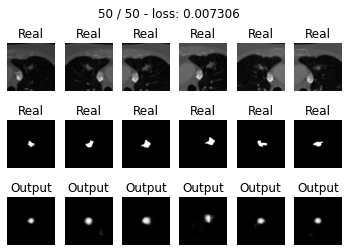

In [17]:
model_segnet = SegNet().to(device)
loss_tr_segnet, loss_val_segnet = train(model_segnet, optim.Adam(model_segnet.parameters(), lr=1e-4), 50, train_loader, val_loader, focal_loss)

In [18]:
train_metrics_series_snet, train_metrics_snet = predict(model_segnet, train_loader, 0.9)
test_metrics_series_snet, test_metrics_snet = predict(model_segnet, test_loader, 0.9)
val_metrics_series_snet, val_metrics_snet = predict(model_segnet, val_loader, 0.9)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Adam with BCE_loss

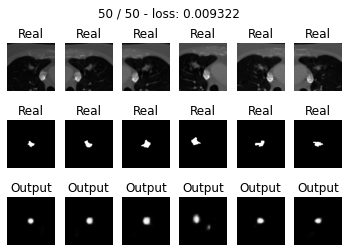

In [19]:
model_segnet2 = SegNet().to(device)
loss_tr_segnet2, loss_val_segnet2 = train(model_segnet2, optim.Adam(model_segnet2.parameters(), lr=1e-4), 50, train_loader, val_loader)

In [20]:
train_metrics_series_snet2, train_metrics_snet2 = predict(model_segnet2, train_loader, 0.9)
test_metrics_series_snet2, test_metrics_snet2 = predict(model_segnet2, test_loader, 0.9)
val_metrics_series_snet2, val_metrics_snet2 = predict(model_segnet2, val_loader, 0.9)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [22]:
metrics_segnet = [train_metrics_snet, train_metrics_snet2, test_metrics_snet, test_metrics_snet2,
                val_metrics_snet, val_metrics_snet2]
df_results_segnet = pd.DataFrame(data=metrics_segnet,
                               index=['Training Focal',
                                      'Training weighted BCE',
                                      'Test Focal',
                                      'Test weighted BCE',
                                      'Validation Focal',
                                      'Validation weighted BCE'],
                               columns=['IoU', 'Accuracy', 'Sensitivity', 'Specificity', 'Dice'])
df_results_segnet

,IoU,Accuracy,Sensitivity,Specificity,Dice
Training Focal,0.013275,0.994202,0.013277,0.999999,0.025171
Training weighted BCE,0.213823,0.995366,0.215988,0.999939,0.347145
Test Focal,0.011079,0.993594,0.011084,0.999999,0.019933
Test weighted BCE,0.142240,0.994596,0.145244,0.999915,0.230792
Validation Focal,0.004401,0.993892,0.004401,1.000000,0.008306
Validation weighted BCE,0.135834,0.994709,0.141027,0.999891,0.219586


# SGD with BCE_Loss

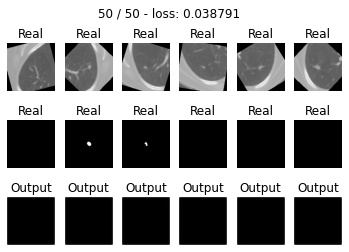

In [ ]:
model_segnet_SGD = SegNet().to(device)
loss_tr_segnet_SGD, loss_val_segnet_SGD = train(model_segnet_SGD, optim.SGD(model_segnet_SGD.parameters(), lr=0.001), 50, train_loader, val_loader)

In [ ]:
train_metrics_series_snet_SGD, train_metrics_snet_SGD = predict(model_segnet_SGD, train_loader, 0.9)
test_metrics_series_snet_SGD, test_metrics_snet_SGD = predict(model_segnet_SGD, test_loader, 0.9)
val_metrics_series_snet_SGD, val_metrics_snet_SGD = predict(model_segnet_SGD, val_loader, 0.9)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
metrics_segnet_optim = [train_metrics_snet2, train_metrics_snet_SGD, test_metrics_snet2, test_metrics_snet_SGD,
                val_metrics_snet2, val_metrics_snet_SGD]
df_results_segnet_optim = pd.DataFrame(data=metrics_segnet_optim,
                               index=['Training with Adam',
                                      'Training with SGD',
                                      'Test with Adam',
                                      'Test with SGD',
                                      'Validation with Adam',
                                      'Validation wwith SGD'],
                               columns=['IoU', 'Accuracy', 'Sensitivity', 'Specificity', 'Dice'])
df_results_segnet_optim

,IoU,Accuracy,Sensitivity,Specificity,Dice
Training with Adam,0.155954,0.994998,0.157522,0.999941,0.263582
Training with SGD,0.000000,0.994119,0.000000,1.000000,0.000000
Test with Adam,0.111914,0.994422,0.114002,0.999935,0.180398
Test with SGD,0.000000,0.993568,0.000000,1.000000,0.000000
Validation with Adam,0.107499,0.994618,0.109312,0.999928,0.174766
Validation wwith SGD,0.000000,0.993859,0.000000,1.000000,0.000000


# Testing Metrics

In [ ]:
X_test_batch, Y_test_batch = next(iter(train_loader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
X_test_batch.shape


torch.Size([64, 1, 128, 128])

In [ ]:
model_segnet.eval()
X_test_batch = X_test_batch.to(device)
with torch.no_grad():
    Y_test_pred = model_segnet(X_test_batch)
    Y_test_hat = F.sigmoid(Y_test_pred).detach().cpu()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
Y_test_hat[Y_test_hat >= 0.9] = 1.0
Y_test_hat[Y_test_hat < 0.9] = 0.0


In [ ]:
Y_test_hat[0][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
#IoU
intersection = torch.logical_and(Y_test_batch, Y_test_hat)
union = torch.logical_or(Y_test_batch, Y_test_hat)
print(intersection.sum(), union.sum(), intersection.sum().item()/union.sum().item())

tensor(0) tensor(7449) 0.0


In [ ]:
TP = torch.sum(torch.logical_and(Y_test_hat == 1, Y_test_batch == 1))
TN = torch.sum(torch.logical_and(Y_test_hat == 0, Y_test_batch == 0))
FP = torch.sum(torch.logical_and(Y_test_hat == 1, Y_test_batch == 0))
FN = torch.sum(torch.logical_and(Y_test_hat == 0, Y_test_batch == 1))
print(TP, TN, FP, FN)

tensor(0) tensor(1041127) tensor(0) tensor(7449)


In [ ]:
#Accuracy
(TP+TN)/(TP+TN+FP+FN) 

tensor(0.9929)

In [ ]:
(TP.item()+TN.item())/(TP.item()+TN.item()+FP.item()+FN.item())

0.9928960800170898

U_Net

In [23]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        # self.pool0 = nn.MaxPool2d(2, 2, padding=0)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2, padding=0)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=0)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=0)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(128, 1, 3, padding=1)
        # self.upsample3 = nn.Upsample(256)  # 128 -> 256
        # self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        # e0 = F.relu(self.enc_conv0(x))
        # e01 = self.pool0(e0)
        e1 = F.relu(self.enc_conv1(x))
        e11 = self.pool1(e1)
        e2 = F.relu(self.enc_conv2(e11))
        e21 = self.pool2(e2)
        e3 = F.relu(self.enc_conv3(e21))
        e31 = self.pool3(e3)


        # bottleneck
        b = F.relu(self.bottleneck_conv(e31))

        # decoder
        d0 = self.upsample0(b)
        d01 = F.relu(self.dec_conv0(torch.cat([d0,e3],1)))
        d1 = self.upsample1(d01)
        d11 = F.relu(self.dec_conv1(torch.cat([d1,e2],1)))
        d2 = self.upsample2(d11)
        d21 = self.dec_conv2(torch.cat([d2,e1],1))
        # d3 = self.upsample3(d21)
        # d31 = self.dec_conv2(torch.cat([d3,e0],1))
        return d21

In [24]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        # self.pool0 = nn.Conv2d(64,64,4, stride = 2, padding = 1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool1 = nn.Conv2d(64,64,4, stride = 2, padding = 1)   # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.Conv2d(64,64,4, stride = 2, padding = 1)   # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.Conv2d(64,64,4, stride = 2, padding = 1)   # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(64,64,4, stride = 2, padding = 1)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64,64,4, stride = 2, padding = 1)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(64,64,4, stride = 2, padding = 1)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(128, 1, 3, padding=1)
        # self.upsample3 = nn.ConvTranspose2d(64,64,4, stride = 2, padding = 1)  # 128 -> 256
        # self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        # e0 = F.relu(self.enc_conv0(x))
        # e01 = self.pool0(e0)
        e1 = F.relu(self.enc_conv1(x))
        e11 = self.pool1(e1)
        e2 = F.relu(self.enc_conv2(e11))
        e21 = self.pool2(e2)
        e3 = F.relu(self.enc_conv3(e21))
        e31 = self.pool3(e3)


        # bottleneck
        b = F.relu(self.bottleneck_conv(e31))

        # decoder
        d0 = self.upsample0(b)
        d01 = F.relu(self.dec_conv0(torch.cat([d0,e3],1)))
        d1 = self.upsample1(d01)
        d11 = F.relu(self.dec_conv1(torch.cat([d1,e2],1)))
        d2 = self.upsample2(d11)
        d21 = self.dec_conv2(torch.cat([d2,e1],1))
        # d3 = self.upsample3(d21)
        # d31 = self.dec_conv2(torch.cat([d3,e0],1))
        return d21

# Unet with upsample, BCE_loss, Adam

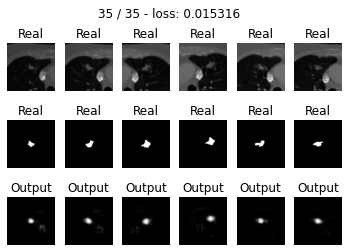

In [25]:
model_unet = UNet().to(device)
loss_tr_unet, loss_val_unet = train(model_unet, optim.Adam(model_unet.parameters(), lr=1e-4), 35, train_loader, val_loader)

Text(0, 0.5, 'Loss')

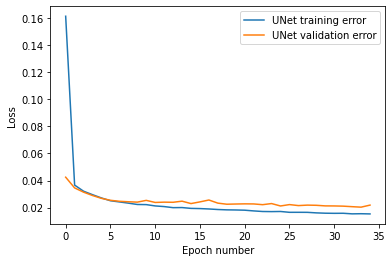

In [33]:
plt.plot(range(len(loss_tr_unet)), loss_tr_unet)
plt.plot(range(len(loss_val_unet)), loss_val_unet)
plt.legend(('UNet training error','UNet validation error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

In [34]:
train_metrics_series_unet, train_metrics_unet = predict(model_unet, train_loader, 0.5)
test_metrics_series_unet, test_metrics_unet = predict(model_unet, test_loader, 0.5)
val_metrics_series_unet, val_metrics_unet = predict(model_unet, val_loader, 0.5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [28]:
metrics_unet = [train_metrics_unet, test_metrics_unet, val_metrics_unet]
df_results_unet = pd.DataFrame(data=metrics_unet,
                               index=['Training Upsample',
                                      'Test Upsample',
                                      'Validation Upsample'],
                               columns=['IoU', 'Accuracy', 'Sensitivity', 'Specificity', 'Dice'])
df_results_unet

,IoU,Accuracy,Sensitivity,Specificity,Dice
Training Upsample,0.179207,0.994948,0.188310,0.999719,0.299662
Test Upsample,0.145333,0.994373,0.158733,0.999673,0.236679
Validation Upsample,0.123642,0.994412,0.130033,0.999735,0.201798


# Unet with transpose_cov, BCE_loss, Adam 

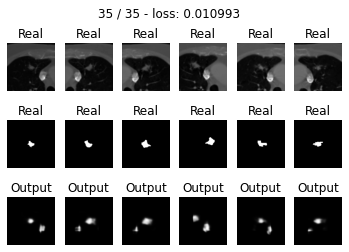

In [47]:
model_unet2 = UNet2().to(device)
loss_tr_unet2, loss_val_unet2 = train(model_unet2, optim.Adam(model_unet2.parameters(), lr=1e-4), 35, train_loader, val_loader)


Text(0, 0.5, 'Loss')

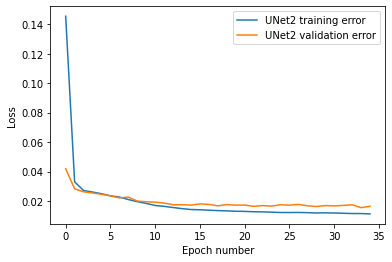

In [35]:
plt.plot(range(len(loss_tr_unet2)), loss_tr_unet2)
plt.plot(range(len(loss_val_unet2)), loss_val_unet2)
plt.legend(('UNet2 training error','UNet2 validation error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')


In [36]:
train_metrics_series_unet2, train_metrics_unet2 = predict(model_unet2, train_loader, 0.5)
test_metrics_series_unet2, test_metrics_unet2 = predict(model_unet2, test_loader, 0.5)
val_metrics_series_unet2, val_metrics_unet2 = predict(model_unet2, val_loader, 0.5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [37]:
metrics_unet = [train_metrics_unet, train_metrics_unet2, test_metrics_unet, test_metrics_unet2,
                val_metrics_unet, val_metrics_unet2]
df_results_unet = pd.DataFrame(data=metrics_unet,
                               index=['Training Upsample',
                                      'Training Transposed Conv',
                                      'Test Upsample',
                                      'Test Transposed Conv',
                                      'Validation Upsample',
                                      'Validation Transposed Conv'],
                               columns=['IoU', 'Accuracy', 'Sensitivity', 'Specificity', 'Dice'])
df_results_unet

,IoU,Accuracy,Sensitivity,Specificity,Dice
Training Upsample,0.174420,0.994903,0.183049,0.999717,0.292299
Training Transposed Conv,0.460922,0.995878,0.611130,0.998102,0.627154
Test Upsample,0.147810,0.994430,0.161905,0.999675,0.239775
Test Transposed Conv,0.365987,0.995278,0.523114,0.998121,0.512207
Validation Upsample,0.117292,0.994362,0.123761,0.999709,0.192283
Validation Transposed Conv,0.345820,0.994810,0.516995,0.998006,0.482516


# Unet with Transpose-cov, BCE_Loss, SGD,

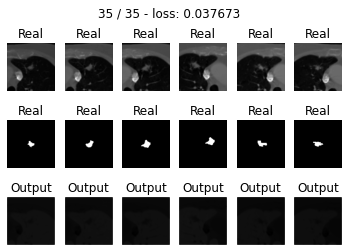

In [31]:
model_unet2_SGD = UNet2().to(device)
loss_tr_unet2_SGD, loss_val_unet2_SGD = train(model_unet2_SGD, optim.SGD(model_unet2_SGD.parameters(), lr=0.01), 35, train_loader, val_loader)


In [32]:
train_metrics_series_unet2_SGD, train_metrics_unet2_SGD = predict(model_unet2_SGD, train_loader, 0.5)
test_metrics_series_unet2_SGD, test_metrics_unet2_SGD = predict(model_unet2_SGD, test_loader, 0.5)
val_metrics_series_unet2_SGD, val_metrics_unet2_SGD = predict(model_unet2_SGD, val_loader, 0.5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [54]:
metrics_unet_SGD_and_Adam = [train_metrics_unet2, train_metrics_unet2_SGD, test_metrics_unet2, test_metrics_unet2_SGD,
                val_metrics_unet2, val_metrics_unet2_SGD]
df_results_unet_SGD_and_Adam = pd.DataFrame(data=metrics_unet_SGD_and_Adam,
                               index=['Training with Adam',
                                      'Training with SGD',
                                      'Test with Adam',
                                      'Test with SGD',
                                      'Validation with Adam',
                                      'Validation with SGD'],
                               columns=['IoU', 'Accuracy', 'Sensitivity', 'Specificity', 'Dice'])
df_results_unet_SGD_and_Adam

,IoU,Accuracy,Sensitivity,Specificity,Dice
Training with Adam,0.315266,0.995597,0.348167,0.999397,0.475292
Training with SGD,0.000000,0.994134,0.000000,1.000000,0.000000
Test with Adam,0.259056,0.995159,0.288891,0.999494,0.388128
Test with SGD,0.000000,0.993570,0.000000,1.000000,0.000000
Validation with Adam,0.249112,0.995129,0.284668,0.999445,0.371117
Validation with SGD,0.000000,0.993859,0.000000,1.000000,0.000000


In [ ]:
def plot_predict(model, data, threshold, epoch):
    model.eval()
    for i, (X, Y) in enumerate(data):
        if i == epoch:
            X = X.to(device)
            with torch.no_grad():
                Y_pred = model(X)
            Y_hat = F.sigmoid(Y_pred).detach().cpu()
            Y_hat[Y_hat >= threshold] = 1.0
            Y_hat[Y_hat < threshold] = 0.0
            for idx in range(Y.shape[0]):
                plt.imshow(Y[idx].squeeze(), alpha=0.5, cmap='Reds')
                plt.imshow(Y_hat[idx].squeeze(), alpha=0.5, cmap='Blues')
                plt.imshow(X[idx].cpu().numpy().squeeze(0), alpha=0.3, cmap='gray')
                plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


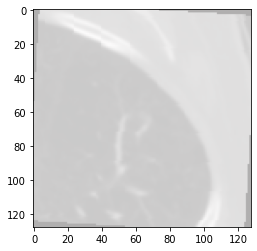

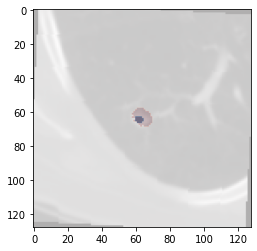

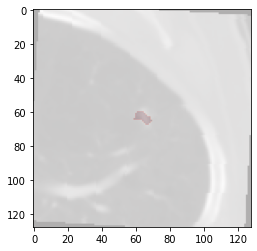

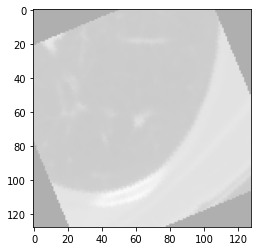

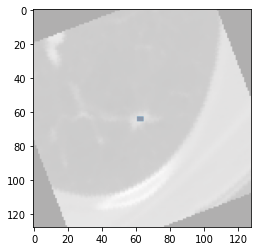

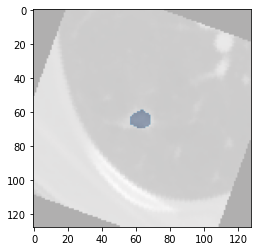

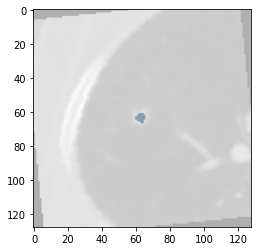

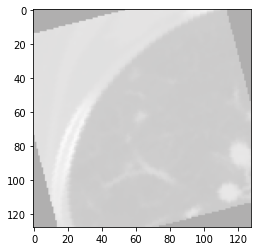

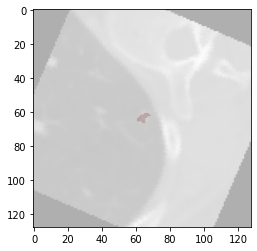

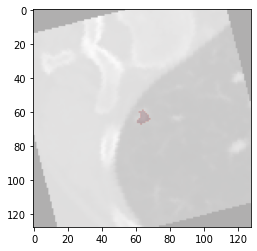

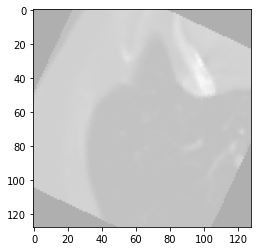

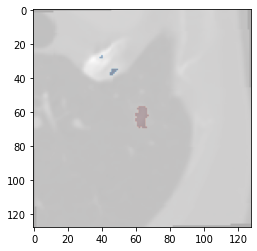

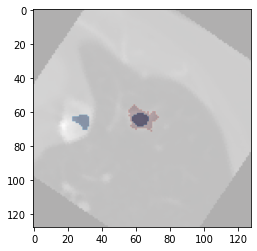

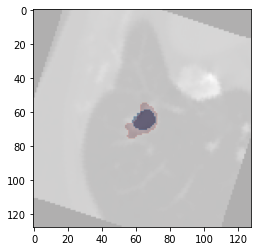

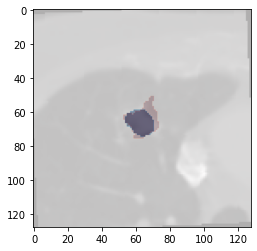

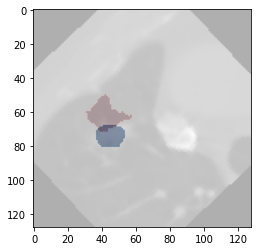

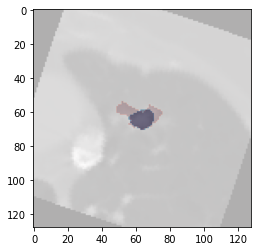

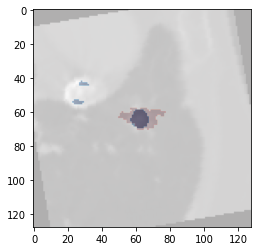

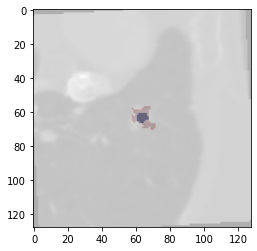

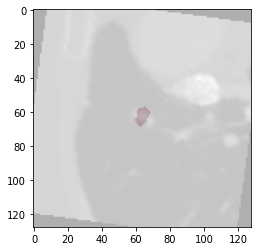

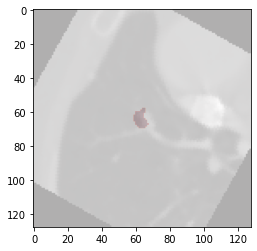

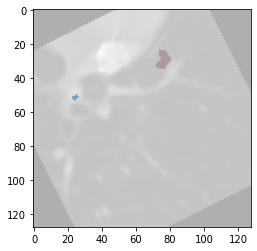

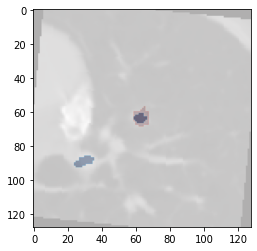

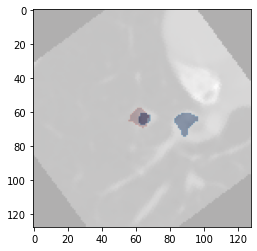

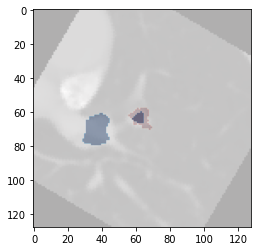

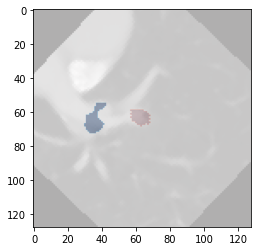

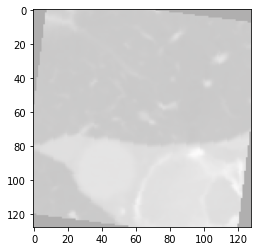

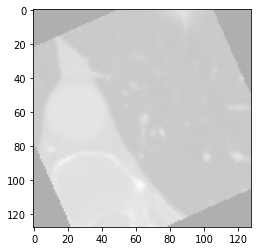

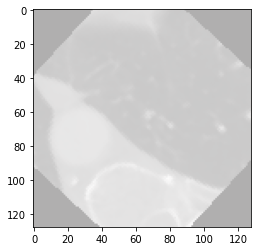

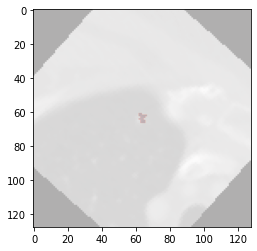

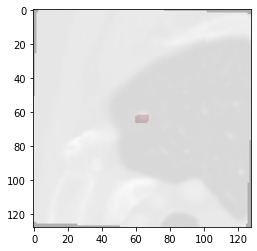

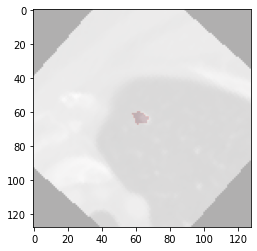

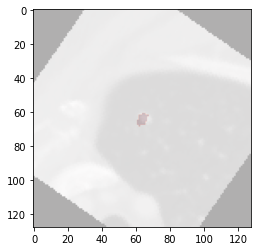

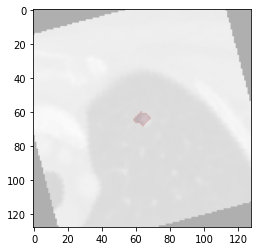

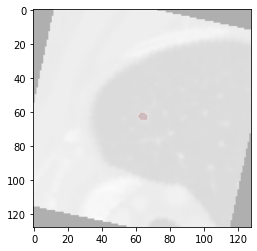

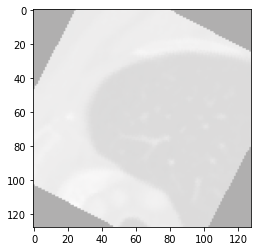

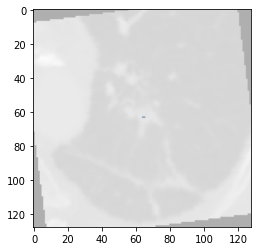

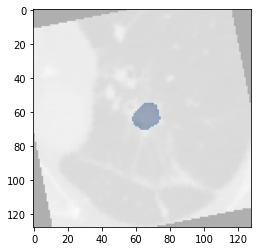

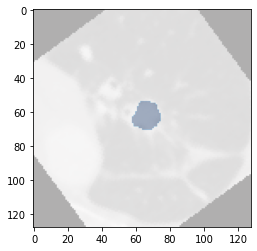

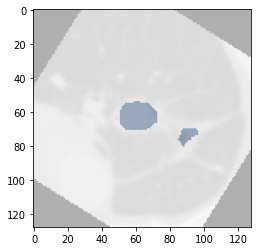

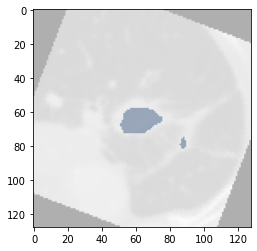

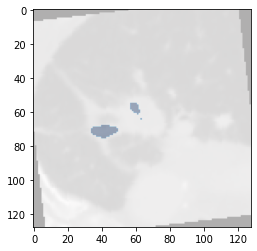

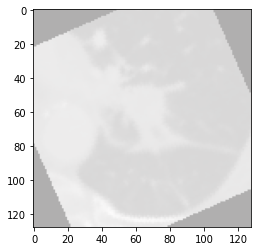

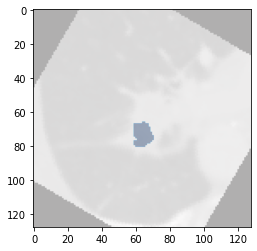

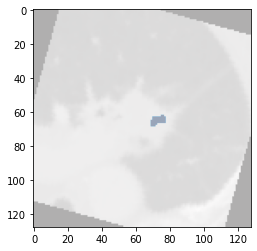

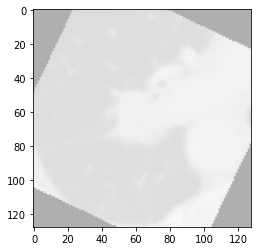

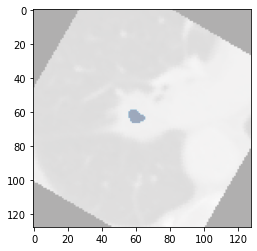

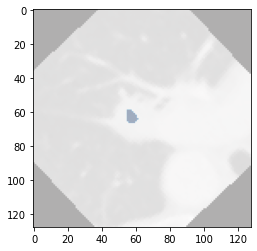

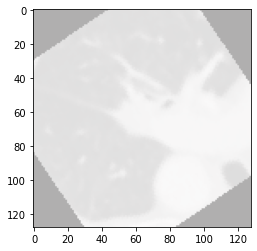

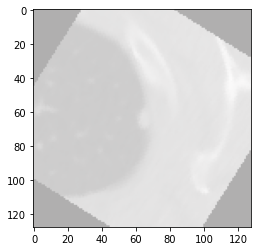

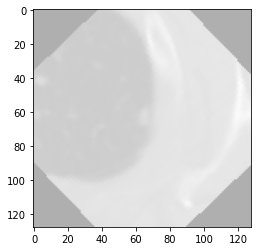

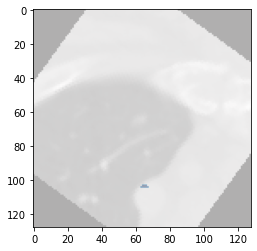

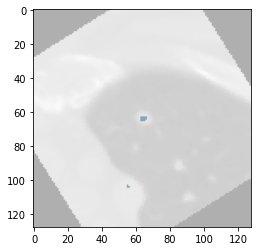

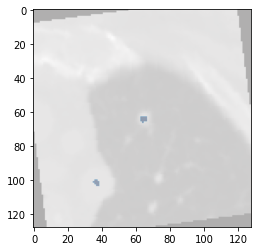

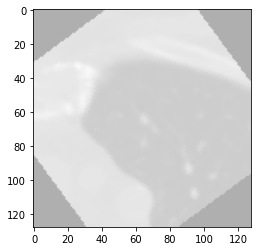

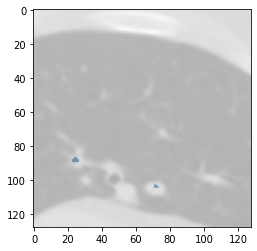

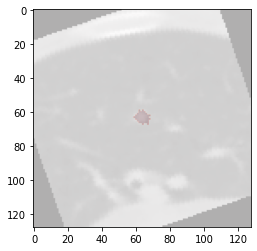

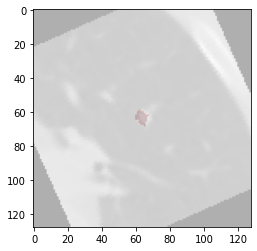

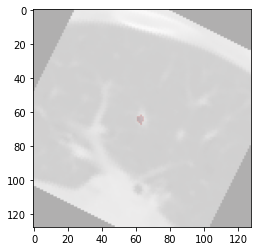

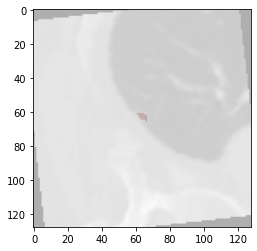

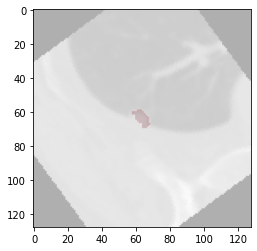

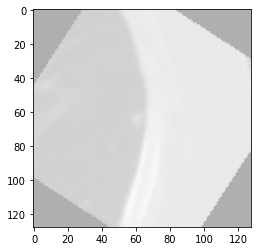

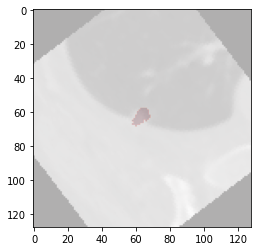

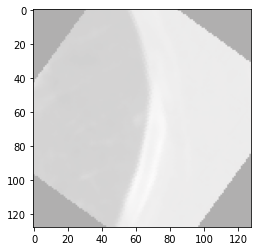

In [ ]:
plot_predict(model_unet, val_loader, 0.5, 0)

# Ensemble

In [38]:
testset0 = LIDC_DLCV(state="test", mask_idx=0)
test_loader0 = DataLoader(testset0, batch_size=batch_size, shuffle=False, num_workers=3)
testset1 = LIDC_DLCV(state="test", mask_idx=1)
test_loader1 = DataLoader(testset1, batch_size=batch_size, shuffle=False, num_workers=3)
testset2 = LIDC_DLCV(state="test", mask_idx=2)
test_loader2 = DataLoader(testset2, batch_size=batch_size, shuffle=False, num_workers=3)
testset3 = LIDC_DLCV(state="test", mask_idx=3)
test_loader3 = DataLoader(testset3, batch_size=batch_size, shuffle=False, num_workers=3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
type(testset0.images)

list

In [39]:
def calculate_ensemble(models, data_loaders, epoch, idx):

    def predict_ensemble(models, data_loaders, epoch, idx):   # calculate the different predictions of different models. For example, this time we calculate the prediction
                                                              # when models is unet with test_loader0 and unet2 with test_loader1,   
        Y_hats = []
        Ys = []
        Xs = []
        for i, data in enumerate(data_loaders):           #enumerate return two elements: index and data  //  i: 0 or 1;  data: test_loader_0 or test_loader_1
            models[i].eval()                              # test different model
            for j, (X_batch, Y_batch) in enumerate(data): # j: index of different batch   (x_batch, Y_batch) is in data, X_batch is the origin image, Y_batch is the annotation
                if j == epoch:                            # calculate the batch j
                    X_batch = X_batch.to(device)
                    with torch.no_grad():
                        Y_pred = models[i](X_batch)
                    Y_hat = F.sigmoid(Y_pred).detach().cpu()
                    Y_hats.append(Y_hat[idx])
                    Ys.append(Y_batch[idx])
                    Xs.append(X_batch[idx])
                    #Y = Y_batch[idx]
        return Y_hats, Ys, Xs

    def average_ensemble(Y_hats, Ys):

      Y_hats_mean = torch.mean(torch.cat(Y_hats,0), 0)      #torch.mean's input is tensor, while Y_hats is list, using torch.cat() can connect list with 0 to produce a tensor without changing the sum of Y-hats
      Y_hats_std = torch.std(torch.cat(Y_hats,0), 0)
      Ys_mean = torch.mean(torch.cat(Ys,0), 0)
      Ys_std = torch.std(torch.cat(Ys,0), 0)
        # Y_hats_mean = torch.mean(torch.cat(Y_hats, 0), 0)
        # Y_hats_std = torch.std(torch.cat(Y_hats, 0), 0)
        # Ys_mean = torch.mean(torch.cat(Ys, 0), 0)
        # Ys_std = torch.std(torch.cat(Ys, 0), 0)

      return Y_hats_mean, Y_hats_std, Ys_mean, Ys_std

    def plot_ensemble(Y_hats, Ys, Xs):
        plt.imshow(Ys, alpha=0.5, cmap='Reds')
        plt.imshow(Y_hats, alpha=0.5, cmap='Blues')
        plt.imshow(Xs[0].squeeze().cpu(), alpha=0.3, cmap='gray')
        plt.show()
    
    Y_hats, Ys, Xs = predict_ensemble(models, data_loaders, epoch, idx)
    Y_hats_mean, Y_hats_std, Ys_mean, Ys_std = average_ensemble(Y_hats, Ys)
    plot_ensemble(Y_hats_mean, Ys_mean, Xs)
    plot_ensemble(Y_hats_std, Ys_std, Xs)
   # plot_ensemble(Y_hats_mean,Y, Xs)
    print(Y_hats)

In [40]:
data_loaders = [test_loader0, test_loader1]
models = [model_unet, model_unet2]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


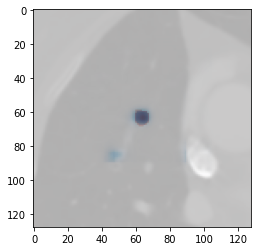

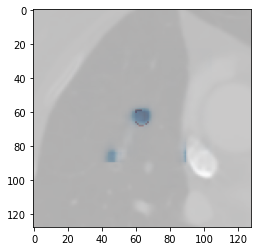

[tensor([[[2.0075e-03, 6.5003e-05, 2.0249e-05,  ..., 4.1060e-06,
          2.3328e-05, 1.5022e-03],
         [6.4745e-05, 2.7531e-07, 6.1484e-08,  ..., 8.9104e-09,
          9.6231e-08, 3.3149e-05],
         [1.1193e-05, 3.4201e-08, 7.6029e-09,  ..., 2.0748e-09,
          2.2167e-08, 1.0369e-05],
         ...,
         [5.5081e-06, 2.4564e-08, 1.0667e-08,  ..., 3.8089e-06,
          1.0045e-05, 2.8756e-04],
         [2.3030e-05, 1.1942e-07, 4.8973e-08,  ..., 1.1053e-05,
          3.0329e-05, 7.1691e-04],
         [6.9395e-04, 1.7594e-05, 7.1978e-06,  ..., 3.0269e-04,
          6.9535e-04, 7.4839e-03]]]), tensor([[[6.6494e-04, 9.8354e-05, 4.2722e-06,  ..., 3.6235e-08,
          1.6519e-06, 2.9279e-05],
         [3.1483e-04, 5.0176e-05, 3.8214e-06,  ..., 2.1986e-08,
          3.3503e-07, 1.2558e-05],
         [5.7771e-05, 1.2435e-05, 1.1837e-06,  ..., 4.4890e-09,
          5.5499e-08, 7.0774e-07],
         ...,
         [4.4481e-05, 3.1506e-05, 1.7174e-05,  ..., 1.3748e-05,
          5.6

In [41]:
calculate_ensemble(models, data_loaders, epoch=1, idx=1)

In [42]:
def plot_ensemble(Y_hats, Ys, Xs):
    for idx in range(len(Ys)):
        plt.imshow(Ys[idx], alpha=0.5, cmap='Reds')
        plt.imshow(Y_hats[idx], alpha=0.5, cmap='Blues')
        plt.imshow(Xs[idx].cpu(), alpha=0.3, cmap='gray')
        plt.show()

In [ ]:
plot_ensemble(Y_preds_unet, Y_unet, X_unet)

# Distance

In [43]:
testset0 = LIDC_DLCV(state="test", mask_idx=0)
test_loader0 = DataLoader(testset0, batch_size=batch_size, shuffle=False, num_workers=0)
testset1 = LIDC_DLCV(state="test", mask_idx=1)
test_loader1 = DataLoader(testset1, batch_size=batch_size, shuffle=False, num_workers=0)
testset2 = LIDC_DLCV(state="test", mask_idx=2)
test_loader2 = DataLoader(testset2, batch_size=batch_size, shuffle=False, num_workers=0)
testset3 = LIDC_DLCV(state="test", mask_idx=3)
test_loader3 = DataLoader(testset3, batch_size=batch_size, shuffle=False, num_workers=0)

In [44]:
def calculate_distance(models, data_loaders, epoch, idx, threshold):
  
  def extract_data(models, data_loaders, epoch, idx):
    # prediction
    Y_hat0 = []
    Y_hat1 = []
    Y_hat2 = []
    Y_hat3 = []
    Y_hat = [Y_hat0, Y_hat1, Y_hat2, Y_hat3]

    # annotation
    Ys_0 = []
    Ys_1 = []
    Ys_2 = []
    Ys_3 = []
    Ys = [Ys_0, Ys_1, Ys_2, Ys_3]

    # origin image
    Xs_0 = []
    Xs_1 = []
    Xs_2 = []
    Xs_3 = []
    Xs = [Xs_0, Xs_1, Xs_2, Xs_3]


    for i, data in enumerate(data_loaders):
      models[i].eval()
      for j, (X_batch, Y_batch) in enumerate(data):
        if j == epoch:
          X_batch = X_batch.to(device)
          with torch.no_grad():
            Y_pred = models[i](X_batch)
          Y_hats = F.sigmoid(Y_pred).detach().cpu()
          Y_hat[i].append(Y_hats[idx])
          Ys[i].append(Y_batch[idx])
          Xs[i].append(X_batch[idx])
      
    return Y_hat, Ys, Xs

  def calculate_d_sy(Y_hat, Ys):
    d_sy = 0
    for i in range(len(Y_hat)):
      prediction = Y_hat[i][0]
      sum = 0
      for j in range(len(Ys)):
        intersection = torch.sum(torch.logical_and(Ys[j][0], prediction))
        union = torch.sum(torch.logical_or(Ys[j][0], prediction))
        try:
          IoU = (intersection.item())/(union.item())
        except ZeroDivisionError:
          IoU = 0
        sum = sum + (1 - IoU)
      d_sy = d_sy + sum
    return d_sy
  
  def calculate_d_ss(Y_hat):
    d_ss = 0
    for i in range(len(Y_hat)):
      prediction = Y_hat[i][0]
      sum = 0
      for j in range(len(Y_hat)):
        intersection = torch.sum(torch.logical_and(Y_hat[j][0], prediction))
        union = torch.sum(torch.logical_or(Y_hat[j][0], prediction))
        try:
          IoU = (intersection.item())/(union.item())
        except ZeroDivisionError:
          IoU = 0
        sum = sum + (1-IoU)
      d_ss = d_ss + sum
    return d_ss

  def calculate_d_yy(Ys):
    d_yy = 0
    for i in range(len(Ys)):
      prediction = Ys[i][0]
      sum = 0
      for j in range(len(Ys)):
        intersection = torch.sum(torch.logical_and(Ys[j][0], prediction))
        union = torch.sum(torch.logical_or(Ys[j][0], prediction))
        try:
          IoU = (intersection.item()/union.item())
        except ZeroDivisionError:
          IoU = 0
        sum = sum + (1 - IoU)
      d_yy = d_yy + sum
    return d_yy

  
  Y_hat, Ys, Xs = extract_data(models, data_loaders, epoch, idx)
  #print(type(Y_hat[1][0]))
  for i in range(len(Y_hat)):
    Y_hat[i][0][Y_hat[i][0] >= threshold] = 1.0
    Y_hat[i][0][Y_hat[i][0] < threshold] = 0.0
  for i in range(len(Ys)):
    Ys[i][0][Ys[i][0] >= threshold] = 1.0
    Ys[i][0][Ys[i][0] < threshold] = 0.0
  d_sy = calculate_d_sy(Y_hat, Ys)
  d_ss = calculate_d_ss(Y_hat)
  d_yy = calculate_d_yy(Ys)
  distance = (2/(len(Ys)*len(Y_hat)) * d_sy - (1/(len(Y_hat)**2)) * d_ss - (1/(len(Ys)**2)) * d_yy)
  print(distance)

In [54]:
models_distance = [model_segnet, model_segnet2, model_unet, model_unet2]
data_loaders_distance = [test_loader0, test_loader1, test_loader2, test_loader3]
calculate_distance(models_distance, data_loaders_distance, epoch = 1, idx =3, threshold = 0.9)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.2270408163265305
